<a href="https://colab.research.google.com/github/Vamsi995/Covariance-Temporal-GCN-for-Traffic-Forecasting/blob/main/cVTGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl

def load_sz_data():
    sz_adj = pd.read_csv(r'/content/sz_adj.csv',header=None)
    adj = np.asarray(sz_adj)
    sz_tf = pd.read_csv(r'/content/sz_speed.csv')
    return sz_tf, adj

def load_los_data():
    los_adj = pd.read_csv(r'/content/los_adj.csv',header=None)
    adj = np.asarray(los_adj)
    los_tf = pd.read_csv(r'/content/los_speed.csv')
    return los_tf, adj


def preprocess_data(data, time_len, rate, seq_len, pre_len):
    train_size = int(time_len * rate)
    train_data = data[0:train_size]
    test_data = data[train_size:time_len]

    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(train_data) - seq_len - pre_len):
        a = train_data[i: i + seq_len + pre_len]
        trainX.append(a[0 : seq_len])
        trainY.append(a[seq_len : seq_len + pre_len])
    for i in range(len(test_data) - seq_len -pre_len):
        b = test_data[i: i + seq_len + pre_len]
        testX.append(b[0 : seq_len])
        testY.append(b[seq_len : seq_len + pre_len])

    trainX1 = np.array(trainX)
    trainY1 = np.array(trainY)
    testX1 = np.array(testX)
    testY1 = np.array(testY)
    return trainX1, trainY1, testX1, testY1

In [2]:
speed, adj = load_sz_data()

In [3]:
adj.shape

(156, 156)

In [4]:
speed.shape

(2976, 156)

In [5]:
import numpy as np
import pandas as pd
import torch


def load_features(feat_path, dtype=np.float32):
    feat_df = pd.read_csv(feat_path)
    feat = np.array(feat_df, dtype=dtype)
    return feat


def load_adjacency_matrix(adj_path, dtype=np.float32):
    adj_df = pd.read_csv(adj_path, header=None)
    adj = np.array(adj_df, dtype=dtype)
    return adj


def generate_dataset(
    data, cov_data, seq_len, pre_len, time_len=None, split_ratio=0.8, normalize=True
):
    """
    :param data: feature matrix
    :param seq_len: length of the train data sequence
    :param pre_len: length of the prediction data sequence
    :param time_len: length of the time series in total
    :param split_ratio: proportion of the training set
    :param normalize: scale the data to (0, 1], divide by the maximum value in the data
    :return: train set (X, Y) and test set (X, Y)
    """
    if time_len is None:
        time_len = data.shape[0]
    if normalize:
        max_val = np.max(data)
        data = data / max_val
    train_size = int(time_len * split_ratio)
    train_data = data[:train_size]
    train_cov = cov_data[:train_size]
    test_data = data[train_size:time_len]
    test_cov = cov_data[train_size:time_len]
    train_X, train_Y, test_X, test_Y = list(), list(), list(), list()
    for i in range(len(train_data) - seq_len - pre_len):
        train_X.append(np.array(train_cov[i : i + seq_len]))
        train_Y.append(np.array(train_data[i + seq_len : i + seq_len + pre_len]))
    for i in range(len(test_data) - seq_len - pre_len):
        test_X.append(np.array(test_cov[i : i + seq_len]))
        test_Y.append(np.array(test_data[i + seq_len : i + seq_len + pre_len]))
    return np.array(train_X), np.array(train_Y), np.array(test_X), np.array(test_Y)


def generate_torch_datasets(
    data, cov_data, seq_len, pre_len, time_len=None, split_ratio=0.8, normalize=True
):
    train_X, train_Y, test_X, test_Y = generate_dataset(
        data,
        cov_data,
        seq_len,
        pre_len,
        time_len=time_len,
        split_ratio=split_ratio,
        normalize=normalize,
    )
    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(train_X), torch.FloatTensor(train_Y)
    )
    test_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(test_X), torch.FloatTensor(test_Y)
    )
    return train_dataset, test_dataset

In [6]:
import argparse
import numpy as np
# import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader


class SpatioTemporalCSVDataModule():
    def __init__(
        self,
        feat_path: str,
        adj_path: str,
        batch_size: int = 64,
        seq_len: int = 12,
        pre_len: int = 3,
        split_ratio: float = 0.8,
        normalize: bool = True,
        features=None,
        adj_matrix=None,
        **kwargs
    ):
        super(SpatioTemporalCSVDataModule, self).__init__()
        self._feat_path = feat_path
        self._adj_path = adj_path
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.pre_len = pre_len
        self.split_ratio = split_ratio
        self.normalize = normalize
        self._feat = load_features(self._feat_path)
        if features is not None:
            self.cov_data = self._feat + features
        else:
          self.cov_data = self._feat
        if adj_matrix is not None:
            self._adj = adj_matrix
        self._feat_max_val = np.max(self._feat)
        self._adj = load_adjacency_matrix(self._adj_path)

        self.train_dataset, self.val_dataset = generate_torch_datasets(
            self._feat,
            self.cov_data,
            self.seq_len,
            self.pre_len,
            split_ratio=self.split_ratio,
            normalize=self.normalize,
        )

    @staticmethod
    def add_data_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--batch_size", type=int, default=32)
        parser.add_argument("--seq_len", type=int, default=12)
        parser.add_argument("--pre_len", type=int, default=3)
        parser.add_argument("--split_ratio", type=float, default=0.8)
        parser.add_argument("--normalize", type=bool, default=True)
        return parser

    def setup(self, stage: str = None):
        (
            self.train_dataset,
            self.val_dataset,
        ) = generate_torch_datasets(
            self._feat,
            self.seq_len,
            self.pre_len,
            split_ratio=self.split_ratio,
            normalize=self.normalize,
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=len(self.val_dataset))

    @property
    def feat_max_val(self):
        return self._feat_max_val

    @property
    def adj(self):
        return self._adj

In [7]:
data_module = SpatioTemporalCSVDataModule("/content/sz_speed.csv", "/content/sz_adj.csv")

In [8]:
import numpy as np
import scipy.sparse as sp
import torch
from torch.nn.functional import normalize


def calculate_laplacian_with_self_loop(matrix):
    matrix = matrix + torch.eye(matrix.size(0))
    row_sum = matrix.sum(1)
    d_inv_sqrt = torch.pow(row_sum, -0.5).flatten()
    d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.0
    d_mat_inv_sqrt = torch.diag(d_inv_sqrt)
    normalized_laplacian = (
        matrix.matmul(d_mat_inv_sqrt).transpose(0, 1).matmul(d_mat_inv_sqrt)
    )
    return normalized_laplacian

In [9]:
from math import nan
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse



class TGCNGraphConvolution(nn.Module):
    def __init__(self, adj, num_gru_units: int, output_dim: int, bias: float = 0.0):
        super(TGCNGraphConvolution, self).__init__()
        self._num_gru_units = num_gru_units
        self._output_dim = output_dim
        self._bias_init_value = bias
        self.register_buffer("laplacian", calculate_laplacian_with_self_loop(torch.FloatTensor(adj)))
        self.weights = nn.Parameter(torch.FloatTensor(self._num_gru_units + 1, self._output_dim))
        self.biases = nn.Parameter(torch.FloatTensor(self._output_dim))
        self.reset_parameters()
        self.covariance = None  # Covariance matrix placeholder
        self.laplacian_mask = nn.Parameter(torch.ones_like(self.laplacian))  # Learnable mask for Laplacian
        self.covariance_mask = nn.Parameter(torch.ones_like(self.laplacian))  # Learnable mask for covariance
        self.bottleneck_scores = None


    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weights)
        nn.init.constant_(self.biases, self._bias_init_value)


    def update_covariance(self, hidden_state, gamma=0.9):

        # print(hidden_state.shape)
        """
        Update covariance matrix dynamically using the hidden state and a decay factor gamma.
        """
        batch_size, num_nodes, num_features = hidden_state.shape
        reshaped_hidden = hidden_state.reshape(-1, num_features)  # Flatten to (batch_size * num_nodes, features)
        current_covariance = torch.cov(reshaped_hidden.T)

        # Initialize or update self.covariance with the same shape as current_covariance
        if self.covariance is None:
            self.covariance = torch.zeros_like(current_covariance)

        # Update self.covariance using the current covariance and decay factor
        # print(hidden_state.shape, self.covariance.shape, current_covariance.shape)
        self.covariance = (gamma * self.covariance + (1 - gamma) * current_covariance) / torch.trace(self.covariance)
        # assert not torch.isnan(self.covariance).any()
        print(self.covariance)
        self.covariance = torch.nan_to_num(self.covariance)



        # Normalize by trace to keep the scale stable
        # self.covariance = self.covariance / torch.trace(self.covariance)

        # if self.covariance is None:
        #     self.covariance = current_covariance
        # else:
        #     self.covariance = gamma * self.covariance + (1 - gamma) * current_covariance

        # self.covariance = self.covariance / torch.trace(self.covariance)  # Trace-normalize
    # Apply the covariance filter
        # self.filtered_covariance, _ = self.covariance_filter(self.covariance, self.top_k)

    def covariance_filter(self, covariance_matrix, top_k):
        """
        Apply a covariance filter by selecting the top-k eigenvectors as a mask.

        Args:
            covariance_matrix (torch.Tensor): Covariance matrix (N, N).
            top_k (int): Number of top eigenvectors to select as the mask.

        Returns:
            torch.Tensor: Filtered covariance matrix.
            torch.Tensor: Selected top eigenvectors.
        """
        # Ensure the covariance matrix is symmetric
        assert torch.allclose(covariance_matrix, covariance_matrix.T), "Matrix must be symmetric."

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(covariance_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        sorted_indices = torch.argsort(eigenvalues, descending=True)
        top_eigenvectors = eigenvectors[:, sorted_indices[:top_k]]

        # Project the covariance matrix using the top eigenvectors
        filtered_matrix = top_eigenvectors @ top_eigenvectors.T

        return filtered_matrix, top_eigenvectors


    def forward(self, inputs, hidden_state):
        batch_size, num_nodes = inputs.shape
        inputs = inputs.reshape((batch_size, num_nodes, 1))
        hidden_state = hidden_state.reshape((batch_size, num_nodes, self._num_gru_units))

        # Update covariance using the current hidden state
        # self.update_covariance(hidden_state)
        # self.covariance, _ = self.covariance_filter(self.covariance, 50)

        masked_laplacian = self.laplacian * self.laplacian_mask
        masked_covariance = self.covariance * self.covariance_mask

        # self.laplacian_filter(self.laplacian, 2)

        # Combine Laplacian and masked covariance as Graph Shift Operator (GSO)
        mask = masked_laplacian + masked_covariance

        # Normalize GSO
        mask = mask / torch.linalg.matrix_norm(mask)

        # Introduce bottleneck weighting (Diagonal Matrix D_B)
        bottleneck_diag = torch.diag(1 - torch.softmax(self.bottleneck_scores, dim=0))  # Shape: (num_nodes, num_nodes)

        # Apply Bottleneck-Weighted Graph Convolution (BWGC)
        bw_mask = mask @ bottleneck_diag # Scale edges by node importance
        # bw_mask = mask # Scale edges by node importance


        # Feature concatenation (input + hidden state)
        concatenation = torch.cat((inputs, hidden_state), dim=2)
        concatenation = concatenation.transpose(0, 1).transpose(1, 2)
        concatenation = concatenation.reshape((num_nodes, (self._num_gru_units + 1) * batch_size))

        # Apply BWGC (message passing)
        a_times_concat = bw_mask @ concatenation  # Bottleneck-weighted aggregation


        # concatenation = torch.cat((inputs, hidden_state), dim=2)
        # concatenation = concatenation.transpose(0, 1).transpose(1, 2)
        # concatenation = concatenation.reshape((num_nodes, (self._num_gru_units + 1) * batch_size))
        # a_times_concat = (mask/torch.linalg.matrix_norm(mask)) @ concatenation
        a_times_concat = a_times_concat.reshape((num_nodes, self._num_gru_units + 1, batch_size))
        a_times_concat = a_times_concat.transpose(0, 2).transpose(1, 2)
        a_times_concat = a_times_concat.reshape((batch_size * num_nodes, self._num_gru_units + 1))
        outputs = a_times_concat @ self.weights + self.biases
        outputs = outputs.reshape((batch_size, num_nodes, self._output_dim))
        outputs = outputs.reshape((batch_size, num_nodes * self._output_dim))
        return outputs

    @property
    def hyperparameters(self):
        return {
            "num_gru_units": self._num_gru_units,
            "output_dim": self._output_dim,
            "bias_init_value": self._bias_init_value,
        }



class TGCNCell(nn.Module):
    def __init__(self, adj, input_dim: int, hidden_dim: int):
        super(TGCNCell, self).__init__()
        self._input_dim = input_dim
        self._hidden_dim = hidden_dim
        self.register_buffer("adj", torch.FloatTensor(adj))
        self.graph_conv1 = TGCNGraphConvolution(
            self.adj, self._hidden_dim, self._hidden_dim * 2, bias=1.0
        )
        self.graph_conv2 = TGCNGraphConvolution(
            self.adj, self._hidden_dim, self._hidden_dim
        )

    def forward(self, inputs, hidden_state):
        # [r, u] = sigmoid(A[x, h]W + b)
        # [r, u] (batch_size, num_nodes * (2 * num_gru_units))
        concatenation = torch.sigmoid(self.graph_conv1(inputs, hidden_state))
        # r (batch_size, num_nodes, num_gru_units)
        # u (batch_size, num_nodes, num_gru_units)
        r, u = torch.chunk(concatenation, chunks=2, dim=1)
        # c = tanh(A[x, (r * h)W + b])
        # c (batch_size, num_nodes * num_gru_units)
        c = torch.tanh(self.graph_conv2(inputs, r * hidden_state))
        # h := u * h + (1 - u) * c
        # h (batch_size, num_nodes * num_gru_units)
        new_hidden_state = u * hidden_state + (1.0 - u) * c
        return new_hidden_state, new_hidden_state

    @property
    def hyperparameters(self):
        return {"input_dim": self._input_dim, "hidden_dim": self._hidden_dim}


class TGCN(nn.Module):
    def __init__(self, adj, hidden_dim: int, **kwargs):
        super(TGCN, self).__init__()
        self._input_dim = adj.shape[0]
        self._hidden_dim = hidden_dim
        self.register_buffer("adj", torch.FloatTensor(adj))
        self.tgcn_cell = TGCNCell(self.adj, self._input_dim, self._hidden_dim)

    def forward(self, inputs):
        batch_size, seq_len, num_nodes = inputs.shape
        assert self._input_dim == num_nodes
        hidden_state = torch.zeros(batch_size, num_nodes * self._hidden_dim).type_as(
            inputs
        )
        output = None
        for i in range(seq_len):
            output, hidden_state = self.tgcn_cell(inputs[:, i, :], hidden_state)
            output = output.reshape((batch_size, num_nodes, self._hidden_dim))
        return output

    @staticmethod
    def add_model_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--hidden_dim", type=int, default=64)
        return parser

    @property
    def hyperparameters(self):
        return {"input_dim": self._input_dim, "hidden_dim": self._hidden_dim}

In [10]:
import torch


def accuracy_f(pred, y):
    """
    :param pred: predictions
    :param y: ground truth
    :return: accuracy, defined as 1 - (norm(y - pred) / norm(y))
    """
    return 1 - torch.linalg.norm(y - pred, "fro") / torch.linalg.norm(y, "fro")


def r2_f(pred, y):
    """
    :param y: ground truth
    :param pred: predictions
    :return: R square (coefficient of determination)
    """
    return 1 - torch.sum((y - pred) ** 2) / torch.sum((y - torch.mean(pred)) ** 2)


def explained_variance_f(pred, y):
    return 1 - torch.var(y - pred) / torch.var(y)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import networkx as nx
import random

class SupervisedForecastTask:
    def __init__(
        self,
        model: nn.Module,
        regressor="linear",
        loss="mse",
        pre_len: int = 3,
        learning_rate: float = 1e-3,
        weight_decay: float = 1.5e-3,
        feat_max_val: float = 1.0,
        gamma: float = 0.9,  # Covariance update factor
        **kwargs
    ):
        self.model = model
        self.gamma = gamma
        self.regressor = (
            nn.Linear(
                self.model.hyperparameters.get("hidden_dim")
                or self.model.hyperparameters.get("output_dim"),
                pre_len,
            )
            if regressor == "linear"
            else regressor
        )
        self._loss = loss
        self.feat_max_val = feat_max_val
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.covariance = None  # Initialize covariance matrix

        self.model.to(self.device)
        if self.regressor is not None:
            self.regressor.to(self.device)

        self.optimizer = optim.Adam(
            list(self.model.parameters()) + list(self.regressor.parameters())
            if self.regressor is not None
            else self.model.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
        )

        self.speed, self.adj = load_sz_data()
        G = nx.from_numpy_array(self.adj)
        self.betweeness_centrality = nx.betweenness_centrality(G)
        self.betweeness_centrality = torch.from_numpy(np.array(list(self.betweeness_centrality.values())).astype(np.float32))

        self.final_dataset = None

        for x, y in data_module.train_dataloader():
            if self.final_dataset is None:
                self.final_dataset = x
            else:
                self.final_dataset = torch.cat([self.final_dataset, x], dim=0)

        for x, y in data_module.val_dataloader():
            self.final_dataset = torch.cat([self.final_dataset, x], dim=0)

        self.final_dataset = self.final_dataset.to(self.device)

        self.adj = torch.tensor(self.adj, dtype=torch.float32).to(self.device)

        self.n = adj.shape[0]
        self.alpha_factor = 0.85  # Scaling factor for alpha
        self.alpha = self.compute_alpha()  # Compute optimized alpha
        self.num_samples = 100

    def compute_alpha(self):
        """ Compute the optimal alpha based on the largest eigenvalue of the adjacency matrix. """
        eigvals = torch.linalg.eigvals(self.adj)  # Compute eigenvalues
        lambda_max = torch.max(torch.abs(eigvals))  # Get largest absolute eigenvalue
        return self.alpha_factor / lambda_max.item() if lambda_max.item() > 0 else 0.1  # Avoid division by zero

    def compute_weights(self, speeds):
        """
        Compute edge weights as inverse min speed.

        :param speeds: (b, t, n) tensor of node speeds
        :return: (b, t, n, n) weighted adjacency matrix
        """
        b, t, n = speeds.shape
        speeds_exp = speeds.unsqueeze(-1).expand(-1, -1, -1, n)  # (b, t, n, n)
        min_speeds = torch.min(speeds_exp, speeds_exp.transpose(2, 3))  # Min speed per edge
        min_speeds = torch.clamp(min_speeds, min=1e-2)  # Avoid very small values
        weights = 1.0 / min_speeds
        weights = weights * self.adj
        return weights * self.adj  # Apply adjacency mask

    def update_bottleneck_scores(self, x):
        """
        Compute approximate betweenness centrality using sampled shortest paths.

        :param x: Tensor (b, t, n) of node speeds
        :return: Tensor (n,) with averaged betweenness centrality scores
        """
        b, t, n = x.shape
        weights = self.compute_weights(x)  # (b, t, n, n)

        centrality_scores = torch.zeros((b, t, n), dtype=torch.float32).to(self.device)

        for batch in range(b):
            for time in range(t):
                G = nx.from_numpy_array(weights[batch, time].cpu().numpy(), create_using=nx.Graph)

                # Sample node pairs
                nodes = list(G.nodes)
                sampled_pairs = random.sample([(u, v) for u in nodes for v in nodes if u != v], self.num_samples)

                # Compute shortest paths on sampled pairs
                betweenness = {node: 0 for node in G.nodes}
                for u, v in sampled_pairs:
                    try:
                        path = nx.shortest_path(G, source=u, target=v, weight='weight')
                        for node in path[1:-1]:  # Exclude source & target
                            betweenness[node] += 1
                    except nx.NetworkXNoPath:
                        continue  # Skip if no path

                # Normalize and store results
                max_bet = max(betweenness.values()) if max(betweenness.values()) > 0 else 1
                centrality_scores[batch, time, :] = torch.tensor(
                    [betweenness[node] / max_bet for node in range(n)], dtype=torch.float32
                ).to(self.device)

        # Average over batch and time dimensions
        avg_centrality = centrality_scores.mean(dim=(0, 1))  # Shape: (n,)

        return avg_centrality

    # def update_bottleneck_scores(self, x):
    #     """
    #     Compute betweenness-like centrality using matrix operations.

    #     :param x: Tensor (b, t, n) of node speeds
    #     :return: Tensor (n,) with averaged centrality scores
    #     """
    #     b, t, n = x.shape
    #     weights = self.compute_weights(x)  # (b, t, n, n)

    #     # Compute inverse of (I - αW) for Katz centrality approximation
    #     I = torch.eye(n, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(self.device)  # (1, 1, n, n)
    #     centrality_matrices = torch.linalg.inv(I - self.alpha * weights).to(self.device) - I  # (b, t, n, n)
    #     centrality_scores = centrality_matrices.sum(dim=-1)  # Sum along columns

    #     # Average over batch and time
    #     avg_centrality = centrality_scores.mean(dim=(0, 1))  # Shape: (n,)

    #     return avg_centrality


    def forward(self, x):
        batch_size, _, num_nodes = x.size()
        hidden = self.model(x)  # (batch_size, num_nodes, hidden_dim)
        hidden = hidden.reshape((-1, hidden.size(2)))  # (batch_size * num_nodes, hidden_dim)
        if self.regressor is not None:
            predictions = self.regressor(hidden)
        else:
            predictions = hidden
        predictions = predictions.reshape((batch_size, num_nodes, -1))  # (batch_size, num_nodes, pre_len)
        return predictions


    def update_covariance(self, x, C_old, gamma, mean):

        b, t, n = x.shape

        if mean is not None:
            C_new = torch.matmul((x - mean).T,x - mean) / x.shape[0]
            if C_old is not None:
                mean = (1-gamma)*mean + gamma * x.mean(0)
                Craw = self.gamma * C_new + (1-gamma) * C_old
            else: # First pass, no C_old
                mean = x.mean(0)
                Craw = C_new
        else:
            if C_old is not None:
                Craw = gamma * torch.cov(x.reshape(b*t, n).T).to(x.device) + (1-gamma) * C_old
            else: # First pass, no C_old
                Craw = torch.cov(x.reshape(b * t, n).T).to(x.device)
                # print(Craw)

        if torch.trace(Craw) != 0:
          C = Craw / torch.trace(Craw)
        else:
          C = Craw

        return C, Craw, mean




    # def update_bottleneck_scores(self, x):


    #     def adjust_degree_centrality(degree_centrality, speeds):
    #         """ Adjust precomputed degree centrality by speed at each time step and average. """
    #         speeds = torch.where(speeds > 0, speeds, torch.tensor(1e-6))  # Avoid division by zero
    #         adjusted = degree_centrality[None, None, :] / speeds  # Shape: (batch, time, nodes)
    #         return torch.mean(adjusted, dim=(0, 1))  # Average over batch & time, shape: (nodes,)


    #     # b, t, n = x.shape

    #     # G = nx.from_numpy_array(self.adj)

    #     # degree_centrality = nx.degree_centrality(G)
    #     # degree_centrality = torch.from_numpy(np.array(list(degree_centrality.values())).astype(np.float32))
    #     degree_centrality = self.betweeness_centrality.to(x.device)
    #     return adjust_degree_centrality(degree_centrality, x)


        # """
        # Computes betweenness centrality for each time step and averages across batches.

        # :param x: Tensor of shape (batch, time, nodes) containing speed values for each node
        # :return: Tensor of shape (nodes,) with average betweenness centrality scores
        # """
        # b, t, n = x.shape  # batch, time, nodes
        # G = nx.from_numpy_array(self.adj)  # Create base graph structure

        # # Store centrality scores for all batch and time steps
        # centrality_scores = torch.zeros((b, t, n), dtype=torch.float32)

        # for batch in range(b):
        #     for time in range(t):
        #         # Get node speeds at this time step
        #         node_speeds = x[batch, time, :].cpu().numpy()  # Convert to numpy

        #         # Compute edge weights based on min speed rule
        #         for u, v in G.edges():
        #             min_speed = min(node_speeds[u], node_speeds[v])
        #             G[u][v]['weight'] = 1 / min_speed if min_speed > 0 else float('inf')  # Avoid division by zero

        #         # Compute betweenness centrality with weighted edges
        #         betweenness = nx.betweenness_centrality(G, weight='weight')

        #         # Store results
        #         centrality_scores[batch, time, :] = torch.tensor(list(betweenness.values()), dtype=torch.float32)

        # # Average over batch and time dimensions
        # avg_betweenness = torch.mean(centrality_scores, dim=(0, 1))  # Shape: (nodes,)

        # return avg_betweenness

    def train(self, train_loader, val_loader, epochs):
        self.model.train()
        if self.regressor is not None:
            self.regressor.train()

        train_losses = []
        mae = []

        for epoch in range(epochs):
            train_loss = 0.0
            C_old = None
            mean = None
            tot_train_loss = []

            for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                # if hasattr(self.model, "tgcn_cell"):
                C, C_old, mean = self.update_covariance(x, C_old, gamma=self.gamma,
                                               mean=mean)

                self.bottleneck_scores = self.update_bottleneck_scores(x)
                # print(self.bottleneck_scores)

                for graph_layer in [self.model.tgcn_cell.graph_conv1, self.model.tgcn_cell.graph_conv2]:
                    graph_layer.covariance = C
                    graph_layer.bottleneck_scores = self.bottleneck_scores

                # Forward pass
                predictions = self.forward(x)

                # Update covariance matrix dynamically
                predictions = predictions.transpose(1, 2).reshape((-1, x.size(2)))  # Reshape predictions
                y = y.reshape((-1, y.size(2)))  # Reshape targets

                # Compute loss
                loss = self.loss(predictions, y)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f}")
            train_losses.append(avg_train_loss)
            mae.append(self.validate(val_loader))

        return train_losses, mae



    def validate(self, val_loader):
        # Validation logic remains the same
        self.model.eval()
        if self.regressor is not None:
            self.regressor.eval()
        # mean = final_dataset.mean(0).mean(0)
        mean = None
        b, t, n = self.final_dataset.shape
        self.final_dataset = self.final_dataset.to(self.device)
        C_old = torch.cov(self.final_dataset.reshape(b*t, n).T)
        val_loss, rmse, mae, r2, explained_var = 0.0, 0.0, 0.0, 0.0, 0.0
        acc = 0
        C_old = C_old.to(self.device)
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                # print(x.shape, mean.shape)
                C, C_old, mean = self.update_covariance(x, C_old, gamma=self.gamma,
                                               mean=mean)

                self.bottleneck_score = self.update_bottleneck_scores(x)

                for graph_layer in [self.model.tgcn_cell.graph_conv1, self.model.tgcn_cell.graph_conv2]:
                    graph_layer.covariance = C
                    graph_layer.bottleneck_scores = self.bottleneck_score


                predictions = self.forward(x)
                predictions = predictions * data_module.feat_max_val

                predictions = predictions.transpose(1, 2).reshape((-1, x.size(2)))  # Reshape predictions
                y = y.reshape((-1, y.size(2)))  # Reshape targets
                y = y * data_module.feat_max_val



                # Compute loss
                loss = self.loss(predictions, y)
                val_loss += loss.item()

                # Metrics
                rmse += torch.sqrt(F.mse_loss(predictions, y)).item()
                mae += F.l1_loss(predictions, y).item()
                r2 += r2_f(predictions, y)
                explained_var += explained_variance_f(predictions, y)
                acc += accuracy_f(predictions, y)

        num_batches = len(val_loader)
        print(
            f"Validation Loss: {val_loss / num_batches:.4f}, RMSE: {rmse / num_batches:.4f}, "
            f"MAE: {mae / num_batches:.4f}, R2: {r2 / num_batches:.4f}, Explained Variance: {explained_var / num_batches:.4f}", f"Accuracy: {acc / num_batches:.4f}"
        )

        return mae / num_batches

    def loss(self, inputs, targets):
        if self._loss == "mse":
            return F.mse_loss(inputs, targets)
        if self._loss == "mse_with_regularizer":
            return utils.losses.mse_with_regularizer_loss(inputs, targets, self)
        raise ValueError(f"Loss '{self._loss}' not supported")



In [20]:
hidden_dim = 32
epochs = 100
model = TGCN(data_module.adj, hidden_dim)

In [21]:
trainer = SupervisedForecastTask(model, feat_max_val=data_module.feat_max_val)

In [ ]:
train_losses, mae = trainer.train(data_module.train_dataloader(), data_module.val_dataloader(), epochs)

Epoch 1/100 - Training: 100%|██████████| 37/37 [07:34<00:00, 12.27s/it]


Epoch 1/100 - Training Loss: 0.0201


Validating: 100%|██████████| 1/1 [01:52<00:00, 112.76s/it]


Validation Loss: 61.1140, RMSE: 7.8175, MAE: 6.5219, R2: 0.4631, Explained Variance: 0.4831 Accuracy: 0.4552


Epoch 2/100 - Training: 100%|██████████| 37/37 [07:31<00:00, 12.20s/it]


Epoch 2/100 - Training Loss: 0.0117


Validating: 100%|██████████| 1/1 [01:52<00:00, 112.45s/it]


Validation Loss: 44.1967, RMSE: 6.6481, MAE: 5.3922, R2: 0.5987, Explained Variance: 0.6042 Accuracy: 0.5367


Epoch 3/100 - Training:  59%|█████▉    | 22/37 [04:33<03:08, 12.60s/it]

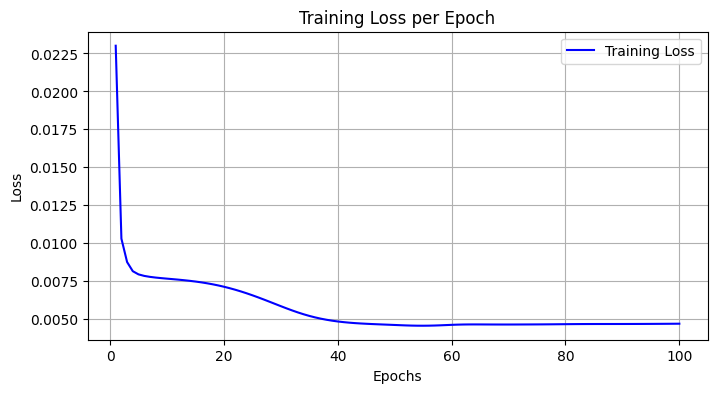

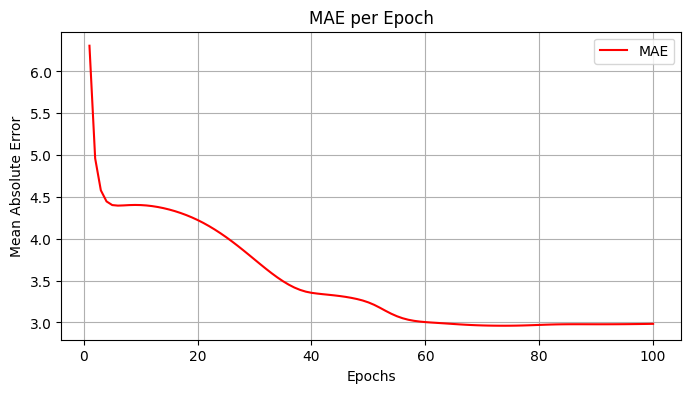

In [161]:
import matplotlib.pyplot as plt

# Assuming you have these lists from your training process
epochs = range(1, len(train_losses) + 1)  # Epoch indices

# Create a figure for Training Loss
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_losses, color='b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()  # Show Training Loss plot

# Create a separate figure for MAE
plt.figure(figsize=(8, 4))
plt.plot(epochs, mae, color='r', label='MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('MAE per Epoch')
plt.legend()
plt.grid(True)
plt.show()  # Show MAE plot


In [163]:
import numpy as np

arr = np.array(train_losses)

# Save the array to a binary .npy file
np.save("with_katz_centrality_train_losses.npy", arr)

# Load the array back from the file
# loaded_arr = np.load("my_array.npy")

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


[67.0, 66.875, 67.75, 67.11111450195312, 65.77777862548828, 66.75, 68.19999694824219, 68.46666717529297, 68.73332977294922, 69.0, 64.44444274902344, 66.875]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115]


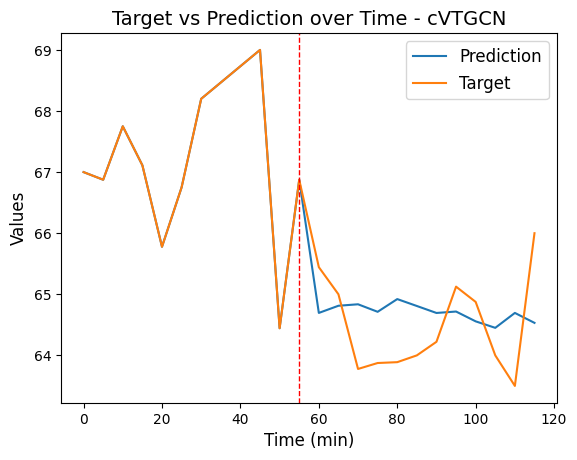

In [ ]:
with torch.no_grad():
    for batch in tqdm(data_module.val_dataloader(), desc="Validating"):
        x, y = batch
        x, y = x.to(trainer.device), y.to(trainer.device)
        # print(x.shape, y.shape)
        x = x[220].reshape(1, -1, x.size(2))
        y = y[220].reshape(1, -1, y.size(2))

        predictions = trainer.forward(x)
        predictions = predictions * data_module.feat_max_val
        y = y * data_module.feat_max_val

        predictions = predictions.transpose(1, 2).reshape((-1, x.size(2)))  # Reshape predictions
        y = y.reshape((-1, y.size(2)))  # Reshape targets



        input = x[0][:, 0].tolist()

        pred = predictions[:, 0].tolist()
        target = y[:, 0].tolist()
        print(input)
        x = [i for i in range(0, 120, 5)]
        print(x)
        plt.plot(x, input + pred, label='Prediction')
        plt.plot(x, input + target, label='Target')

        plt.legend(fontsize=12)
        plt.axvline(x=55, color='red', linestyle='--', linewidth=1)

        # Add a vertical line at the start of the input
        plt.xlabel('Time (min)', fontsize=12)
        plt.ylabel('Values', fontsize=12)
        plt.title('Target vs Prediction over Time - cVTGCN', fontsize=14)



        break

In [ ]:
input = torch.from_numpy(np.asarray(speed.iloc[12:24], dtype=np.float32)).reshape(-1, 12, 156)

# x = input.to(trainer.device)
x = input

In [ ]:

with torch.no_grad():
  predictions = trainer.forward(x)


  predictions = predictions * data_module.feat_max_val

  predictions = predictions.transpose(1, 2).reshape((-1, x.size(2)))  # Reshape predictions




(0.0, 86.42919921875)

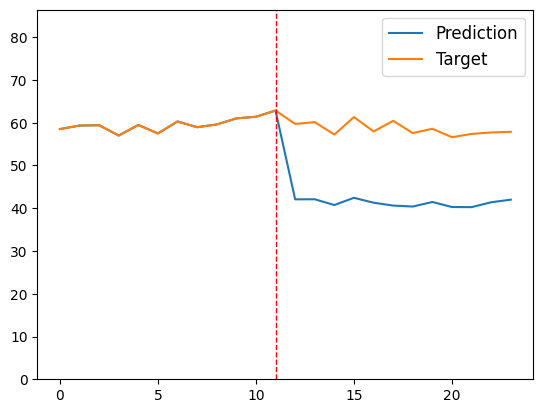

In [ ]:
from matplotlib import pyplot as plt

target = np.asarray(speed.iloc[24:36], dtype=np.float32)[:, 0].tolist()
input = np.asarray(speed.iloc[12:24], dtype=np.float32)[:, 0].tolist()

x = np.linspace(0, 24, 24)


plt.plot(input + predictions[:,0].tolist(), label='Prediction')
plt.plot(input + target, label='Target')

plt.legend(fontsize=12)
ax = plt.gca()
# Add a vertical line at the start of the input
plt.axvline(x=11, color='red', linestyle='--', linewidth=1, label='Input Start')

# ax.set_xlim([xmin, xmax])
ax.set_ylim([0, data_module.feat_max_val])

In [65]:
final_dataset = None

for x, y in data_module.train_dataloader():
    if final_dataset is None:
        final_dataset = x
    else:
        final_dataset = torch.cat([final_dataset, x], dim=0)

for x, y in data_module.val_dataloader():
    final_dataset = torch.cat([final_dataset, x], dim=0)


In [66]:




def validate(self, val_loader):
        self.model.eval()
        if self.regressor is not None:
            self.regressor.eval()
        # mean = final_dataset.mean(0).mean(0)
        mean = None
        b, t, n = final_dataset.shape
        final_dataset.to(self.device)
        C_old = torch.cov(final_dataset.reshape(b*t, n).T)
        val_loss, rmse, mae, r2, explained_var = 0.0, 0.0, 0.0, 0.0, 0.0
        acc = 0
        C_old = C_old.to(self.device)
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                # print(x.shape, mean.shape)
                C, C_old, mean = self.update_covariance(x, C_old, gamma=self.gamma,
                                               mean=mean)

                self.bottleneck_score = self.update_bottleneck_scores(x)

                for graph_layer in [self.model.tgcn_cell.graph_conv1, self.model.tgcn_cell.graph_conv2]:
                    graph_layer.covariance = C
                    graph_layer.bottleneck_scores = self.bottleneck_score


                predictions = self.forward(x)
                predictions = predictions * data_module.feat_max_val

                predictions = predictions.transpose(1, 2).reshape((-1, x.size(2)))  # Reshape predictions
                y = y.reshape((-1, y.size(2)))  # Reshape targets
                y = y * data_module.feat_max_val



                # Compute loss
                loss = self.loss(predictions, y)
                val_loss += loss.item()

                # Metrics
                rmse += torch.sqrt(F.mse_loss(predictions, y)).item()
                mae += F.l1_loss(predictions, y).item()
                r2 += r2_f(predictions, y)
                explained_var += explained_variance_f(predictions, y)
                acc += accuracy_f(predictions, y)

        num_batches = len(val_loader)
        print(
            f"Validation Loss: {val_loss / num_batches:.4f}, RMSE: {rmse / num_batches:.4f}, "
            f"MAE: {mae / num_batches:.4f}, R2: {r2 / num_batches:.4f}, Explained Variance: {explained_var / num_batches:.4f}", f"Accuracy: {acc / num_batches:.4f}"
        )


In [67]:
import torch


def accuracy_f(pred, y):
    """
    :param pred: predictions
    :param y: ground truth
    :return: accuracy, defined as 1 - (norm(y - pred) / norm(y))
    """
    return 1 - torch.linalg.norm(y - pred, "fro") / torch.linalg.norm(y, "fro")


def r2_f(pred, y):
    """
    :param y: ground truth
    :param pred: predictions
    :return: R square (coefficient of determination)
    """
    return 1 - torch.sum((y - pred) ** 2) / torch.sum((y - torch.mean(pred)) ** 2)


def explained_variance_f(pred, y):
    return 1 - torch.var(y - pred) / torch.var(y)

In [68]:
validate(trainer, data_module.val_dataloader())

Validating: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

Validation Loss: 18.5134, RMSE: 4.3027, MAE: 2.9659, R2: 0.8304, Explained Variance: 0.8305 Accuracy: 0.7002


In [ ]:
torch.save(trainer.model.state_dict(), "/content/cVTGCNSZ48S30min.pkl")

In [ ]:
test = TGCN(data_module.adj, hidden_dim)
test.load_state_dict(torch.load("/content/cVTGCNSZ60min.pkl", weights_only=True))
test.eval()

TGCN(
  (tgcn_cell): TGCNCell(
    (graph_conv1): TGCNGraphConvolution()
    (graph_conv2): TGCNGraphConvolution()
  )
)

In [ ]:
# 15min Validating: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]Validation Loss: 27.7364, RMSE: 5.2665, MAE: 3.2937, R2: 0.8559, Explained Variance: 0.8567 Accuracy: 0.9103
# 30min Validating: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]Validation Loss: 39.8364, RMSE: 6.3116, MAE: 3.8155, R2: 0.7937, Explained Variance: 0.7937 Accuracy: 0.8925

# 45min Validating: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]Validation Loss: 51.5813, RMSE: 7.1820, MAE: 4.3116, R2: 0.7338, Explained Variance: 0.7338 Accuracy: 0.8777
# 60min Validating: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]Validation Loss: 62.4549, RMSE: 7.9028, MAE: 4.7294, R2: 0.6787, Explained Variance: 0.6788 Accuracy: 0.8653

In [ ]:
# 15min Validating: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]Validation Loss: 17.9162, RMSE: 4.2328, MAE: 2.9625, R2: 0.8358, Explained Variance: 0.8360 Accuracy: 0.7050
# 30min Validating: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]Validation Loss: 18.5834, RMSE: 4.3108, MAE: 3.0719, R2: 0.8298, Explained Variance: 0.8300 Accuracy: 0.6996


In [ ]:
# SZ - taxi
# 24 S 30min Validating: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]Validation Loss: 18.8457, RMSE: 4.3412, MAE: 3.0485, R2: 0.8273, Explained Variance: 0.8280 Accuracy: 0.6971
# 36 S 30min Validating: 100%|██████████| 1/1 [00:14<00:00, 14.02s/it]Validation Loss: 18.7651, RMSE: 4.3319, MAE: 3.0749, R2: 0.8283, Explained Variance: 0.8294 Accuracy: 0.6980

# 48 S 30min Validating: 100%|██████████| 1/1 [00:06<00:00,  6.92s/it]Validation Loss: 18.6807, RMSE: 4.3221, MAE: 3.0549, R2: 0.8286, Explained Variance: 0.8287 Accuracy: 0.6985


In [ ]:


def validate(self, val_loader):
        self.model.eval()
        if self.regressor is not None:
            self.regressor.eval()
        # mean = final_dataset.mean(0).mean(0)
        mean = None
        b, t, n = final_dataset.shape
        C_old = torch.cov(final_dataset.reshape(b*t, n).T)
        val_loss, rmse, mae, r2, explained_var = 0.0, 0.0, 0.0, 0.0, 0.0
        acc = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                # print(x.shape, mean.shape)
                C, C_old, mean = self.update_covariance(x, C_old, gamma=self.gamma,
                                               mean=mean)

                for graph_layer in [self.model.tgcn_cell.graph_conv1, self.model.tgcn_cell.graph_conv2]:
                    graph_layer.covariance = C


                predictions = self.forward(x)
                predictions = predictions * data_module.feat_max_val

                predictions = predictions.transpose(1, 2).reshape((-1, x.size(2)))  # Reshape predictions
                y = y.reshape((-1, y.size(2)))  # Reshape targets
                y = y * data_module.feat_max_val



                # Compute loss
                loss = self.loss(predictions, y)
                val_loss += loss.item()

                # Metrics
                rmse += torch.sqrt(F.mse_loss(predictions, y)).item()
                mae += F.l1_loss(predictions, y).item()
                r2 += r2_f(predictions, y)
                explained_var += explained_variance_f(predictions, y)
                acc += accuracy_f(predictions, y)

        num_batches = len(val_loader)
        print(
            f"Validation Loss: {val_loss / num_batches:.4f}, RMSE: {rmse / num_batches:.4f}, "
            f"MAE: {mae / num_batches:.4f}, R2: {r2 / num_batches:.4f}, Explained Variance: {explained_var / num_batches:.4f}", f"Accuracy: {acc / num_batches:.4f}"
        )
